# Previsão de Churn

### Discente(s):

    Bruno Antonio dos Santos Bezerra
    Erick Vinicius Rebouças Cruz
    Gabriel Monteiro Lobão

### Framework:
    TensorFlow/Keras

### Requerimentos:
    1. Python 3.9
    2. Tensorflow (conda install -c conda-forge tensorflow-gpu=2.10)
    3. Pandas
    4. Matplotlib
    5. Sklearn
    6. Numpy
    7. Dataset: https://www.kaggle.com/datasets/kapturovalexander/customers-churned-in-telecom-services

### Etapas do Projeto:
    1. Carregamento e Exploração dos Dados
    2. Pré-processamento
    3. Otimização de Hiperparâmetros com Optuna
    4. Analisando dados encontrados
    5. Criação do Modelo KAN ()
    6. Treinamento e Validação do Modelo
    7. Avaliação e Previsões
    8. Previsão Futura (Exemplo)




# 1. Importação de Bibliotecas e dados

In [2]:
import numpy as np # Manipulação de dados numéricos e estruturados.
import pandas as pd
import matplotlib.pyplot as plt # Geração de gráficos.
from sklearn.preprocessing import StandardScaler # Normalização dos dados.
from sklearn.preprocessing import OneHotEncoder # Codificação de variáveis categóricas.

import optuna # Otimização de hiperparâmetros.
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # Algoritmo de otimização para treinar a rede neural.
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import r2_score # Avaliação da precisão do modelo.

import seaborn as sns # Visualização de dados.


/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-28 21:55:33.946496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
df = pd.read_csv('data/customer_churn_telecom_services.csv')
print(df.shape)
df.head()



(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1936.30,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,107.70,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1903.50,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,141.40,Yes


In [4]:
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})
data_positive = df[df['Churn'] == 1]
data_negative = df[df['Churn'] == 0]
df['SeniorCitizen'].unique()

/tmp/ipykernel_34903/1637295412.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


array([0, 1])

# 2. Analise dos dados

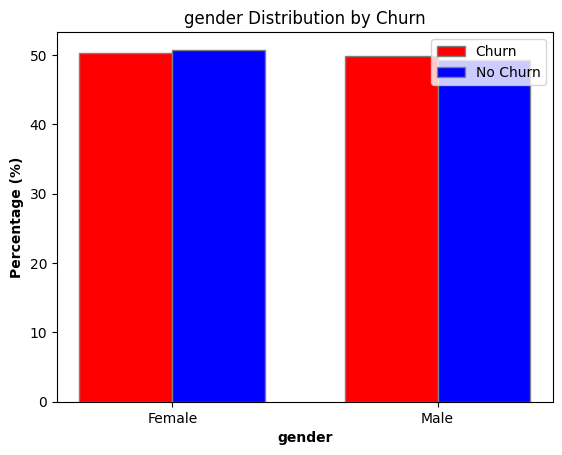

In [5]:
import numpy as np

# Contagem de valores de gênero para churn positivo e negativo
positive_gender_counts = data_positive['gender'].value_counts()
negative_gender_counts = data_negative['gender'].value_counts()

# Calculando as porcentagens
total_positive = positive_gender_counts.sum()
total_negative = negative_gender_counts.sum()

positive_gender_percent = (positive_gender_counts / total_positive) * 100
negative_gender_percent = (negative_gender_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_gender_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_gender_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_gender_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('gender', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_gender_percent))], positive_gender_percent.index)
plt.title('gender Distribution by Churn')
plt.legend()
plt.show()

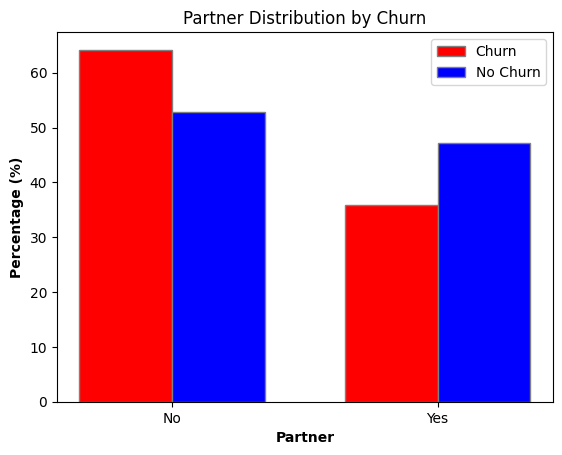

In [6]:
import numpy as np

# Contagem de valores de gênero para churn positivo e negativo
positive_partner_counts = data_positive['Partner'].value_counts()
negative_partner_counts = data_negative['Partner'].value_counts()

# Calculando as porcentagens
total_positive = positive_partner_counts.sum()
total_negative = negative_partner_counts.sum()

positive_partner_percent = (positive_partner_counts / total_positive) * 100
negative_partner_percent = (negative_partner_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_partner_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_partner_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_partner_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('Partner', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_partner_percent))], positive_partner_percent.index)
plt.title('Partner Distribution by Churn')
plt.legend()
plt.show()

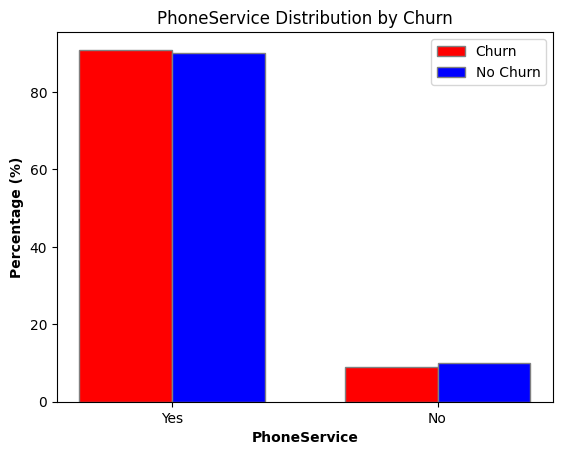

In [7]:
# Contagem de valores de gênero para churn positivo e negativo
positive_PhoneService_counts = data_positive['PhoneService'].value_counts()
negative_PhoneService_counts = data_negative['PhoneService'].value_counts()

# Calculando as porcentagens
total_positive = positive_PhoneService_counts.sum()
total_negative = negative_PhoneService_counts.sum()

positive_PhoneService_percent = (positive_PhoneService_counts / total_positive) * 100
negative_PhoneService_percent = (negative_PhoneService_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_PhoneService_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_PhoneService_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_PhoneService_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('PhoneService', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_PhoneService_percent))], positive_PhoneService_percent.index)
plt.title('PhoneService Distribution by Churn')
plt.legend()
plt.show()

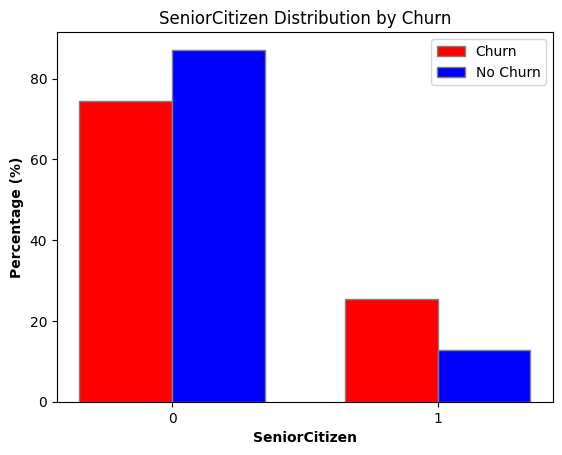

In [8]:
# Contagem de valores de gênero para churn positivo e negativo
positive_SeniorCitizen_counts = data_positive['SeniorCitizen'].value_counts()
negative_SeniorCitizen_counts = data_negative['SeniorCitizen'].value_counts()

# Calculando as porcentagens
total_positive = positive_SeniorCitizen_counts.sum()
total_negative = negative_SeniorCitizen_counts.sum()

positive_SeniorCitizen_percent = (positive_SeniorCitizen_counts / total_positive) * 100
negative_SeniorCitizen_percent = (negative_SeniorCitizen_counts / total_negative) * 100

# Definindo a posição das barras
bar_width = 0.35
r1 = np.arange(len(positive_SeniorCitizen_percent))
r2 = [x + bar_width for x in r1]

# Plotando os dados
plt.bar(r1, positive_SeniorCitizen_percent.values, color='red', width=bar_width, edgecolor='grey', label='Churn')
plt.bar(r2, negative_SeniorCitizen_percent.values, color='blue', width=bar_width, edgecolor='grey', label='No Churn')

# Adicionando os rótulos e título
plt.xlabel('SeniorCitizen', fontweight='bold')
plt.ylabel('Percentage (%)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_SeniorCitizen_percent))], positive_SeniorCitizen_percent.index)
plt.title('SeniorCitizen Distribution by Churn')
plt.legend()
plt.show()

# 3. Pre-processamento de dados

In [9]:
df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']] = df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']].replace({'Yes': 1, 'No': 0})
df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].replace({'Yes': 1, 'No': 0, 'No internet service': 0})
df['gender'] = df['gender'].replace({'Female':1, 'Male':0})
#df['InternetService'] = df['InternetService'].replace({'Fiber optic': 2, 'DSL': 1 , 'No': 0})
df['MultipleLines'] =  df['MultipleLines'].replace({'No phone service': -1})
df.head()

/tmp/ipykernel_34903/1775762302.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']] = df[['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_34903/1775762302.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'Devi

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,-1,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1936.30,0
2,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,107.70,1
3,0,0,0,0,45,0,-1,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1903.50,0
4,1,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,141.40,1


In [10]:
colunas = ['PaymentMethod', 'Contract', 'InternetService']
ohe = OneHotEncoder(dtype=int)

colunas_ohe = ohe.fit_transform(df[colunas]).toarray()
dados = pd.concat([df, pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names_out(colunas))], axis=1)

dados2 = dados.drop(colunas, axis=1)
data = dados2
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,1,0,1,0,1,0,-1,0,1,0,...,0,0,1,0,1,0,0,1,0,0
1,0,0,0,0,34,1,0,1,0,1,...,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,2,1,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0
3,0,0,0,0,45,0,-1,1,0,1,...,1,0,0,0,0,1,0,1,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,1,0,1,...,0,0,0,1,0,1,0,1,0,0
7039,1,0,1,1,72,1,1,0,1,1,...,0,1,0,0,0,1,0,0,1,0
7040,1,0,1,1,11,0,-1,1,0,0,...,0,0,1,0,1,0,0,1,0,0
7041,0,1,1,0,4,1,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [12]:
data = data.fillna(0)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


def k_fold_train_val_test(data, k=5, test_size=0.2, random_state=42):

    # Garante reprodutibilidade
    np.random.seed(random_state)
    
    # Número total de amostras
    n_samples = len(data)
    
    # Separação inicial entre conjunto de treinamento+validação e conjunto de teste
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # Número de amostras para teste
    n_test = int(n_samples * test_size)
    
    # Índices para teste (fixos para todos os folds)
    test_indices = indices[:n_test]
    
    # Índices para treinamento + validação
    train_val_indices = indices[n_test:]
    
    # Aplicar k-fold nos índices de treinamento + validação
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Lista para armazenar os índices de cada fold
    fold_indices = []
    
    # Iterar sobre os splits do k-fold
    for train_idx, val_idx in kf.split(train_val_indices):
        # Mapear os índices do split para os índices originais do dataset
        train_indices = train_val_indices[train_idx]
        val_indices = train_val_indices[val_idx]
        
        # Armazenar os índices deste fold
        fold_indices.append((train_indices, val_indices, test_indices))
    
    return fold_indices


folds = k_fold_train_val_test(data, k=5, test_size=0.25, random_state=42)


# Troque o valor de fold_order para 0, 1, 2, 3 ou 4 para escolher um dos folds
fold_order = 0 #
df_treino = data.iloc[folds[fold_order][0]]
df_test = data.iloc[folds[fold_order][1]]
df_validacao = data.iloc[folds[fold_order][2]]


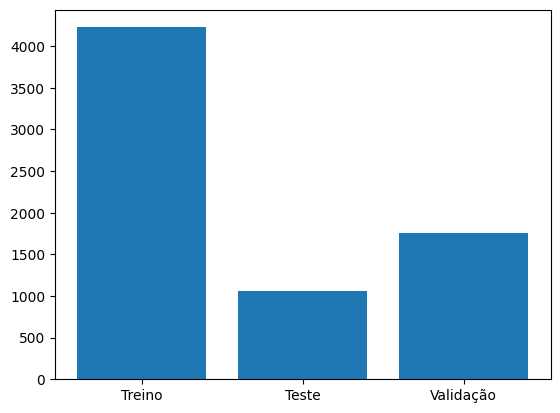

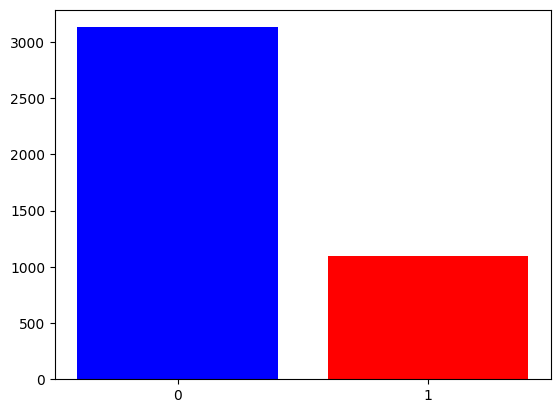

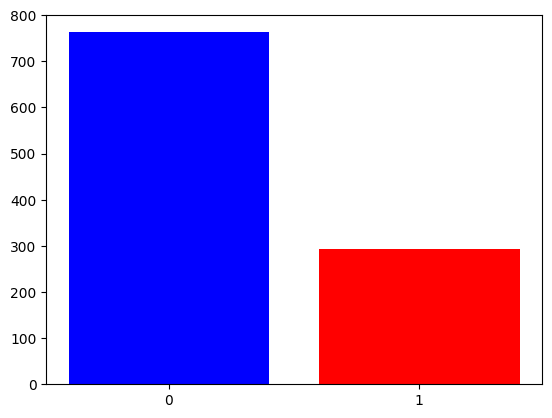

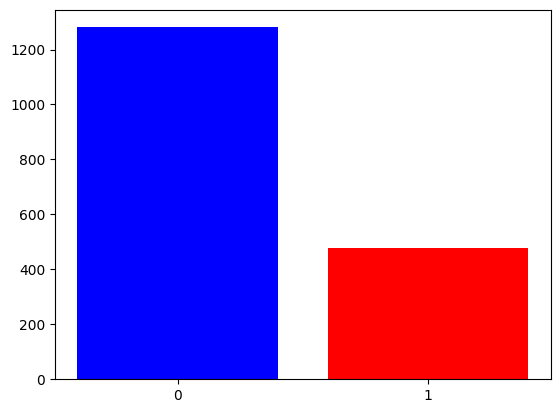

In [26]:




# Plotando a quantidade de dados de treino e teste.
plt.bar(['Treino', 'Teste', 'Validação'], [df_treino.shape[0], df_test.shape[0], df_validacao.shape[0]])
plt.show()

plt.bar(df_treino['Churn'].value_counts().index, df_treino['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()

plt.bar(df_test['Churn'].value_counts().index, df_test['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()

plt.bar(df_validacao['Churn'].value_counts().index, df_validacao['Churn'].value_counts(), color=['blue', 'red'])
plt.xticks([0, 1])
plt.show()


# Separando os dados de entrada e saída.
X_treino = df_treino.drop(columns=['Churn'])
y_treino = df_treino['Churn']

X_test = df_test.drop(columns=['Churn'])
y_test = df_test['Churn']

X_val = df_validacao.drop(columns=['Churn'])
y_val = df_validacao['Churn']


In [ ]:
X_treino

In [27]:


scaler = StandardScaler()
X_train = scaler.fit_transform(X_treino)
y_train = y_treino

X_val = scaler.transform(X_val)
y_val = y_val

X_test = scaler.transform(X_test)
y_test = y_test



In [ ]:
X_train.shape

In [ ]:
#Data Cleaning



# 4. Modelos

### MLP

In [28]:
input_dim = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])



early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

2025-02-28 22:11:16.219372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-28 22:11:16.414233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-28 22:11:16.417500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-28 22:11:16.422201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/100
133/133 [==============================] - 2s 12ms/step - loss: 0.4880 - accuracy: 0.7622 - precision: 0.6000 - recall: 0.2491 - val_loss: 0.4242 - val_accuracy: 0.7909 - val_precision: 0.6555 - val_recall: 0.4885
Epoch 2/100
133/133 [==============================] - 1s 8ms/step - loss: 0.4463 - accuracy: 0.7835 - precision: 0.6141 - recall: 0.4443 - val_loss: 0.4210 - val_accuracy: 0.8045 - val_precision: 0.6709 - val_recall: 0.5532
Epoch 3/100
133/133 [==============================] - 1s 9ms/step - loss: 0.4399 - accuracy: 0.7825 - precision: 0.6075 - recall: 0.4562 - val_loss: 0.4182 - val_accuracy: 0.8040 - val_precision: 0.6658 - val_recall: 0.5616
Epoch 4/100
133/133 [==============================] - 1s 9ms/step - loss: 0.4337 - accuracy: 0.7877 - precision: 0.6271 - recall: 0.4480 - val_loss: 0.4167 - val_accuracy: 0.8080 - val_precision: 0.6707 - val_recall: 0.5783
Epoch 5/100
133/133 [==============================] - 1s 9ms/step - loss: 0.4331 - accuracy: 0.785


Resultados no Teste:
- Acurácia: 0.8032
- Precisão: 0.7028
- Recall: 0.5068


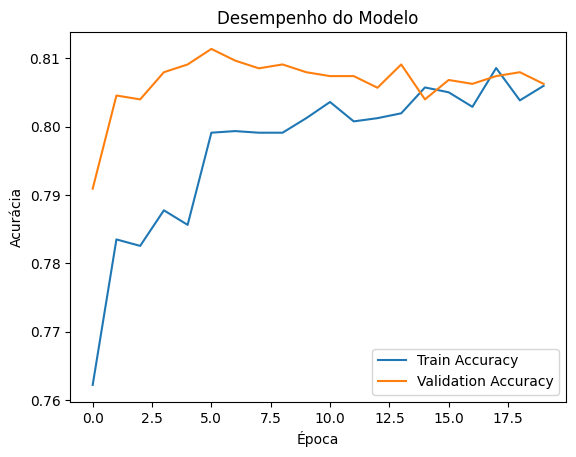

34/34 [==============================] - 0s 940us/step


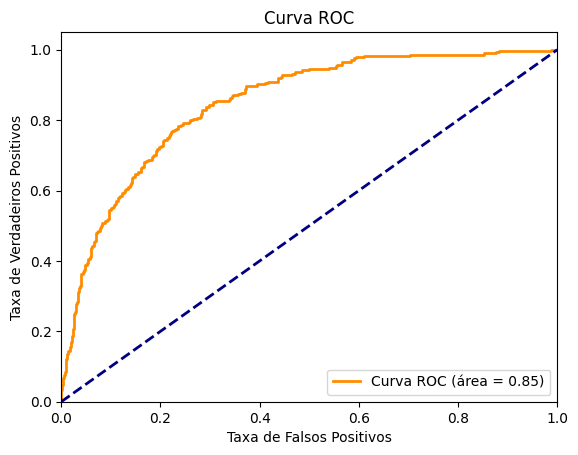

In [30]:
from sklearn.metrics import roc_curve, auc

# Avaliação do modelo no conjunto de teste
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f'''
Resultados no Teste:
- Acurácia: {test_results[1]:.4f}
- Precisão: {test_results[2]:.4f}
- Recall: {test_results[3]:.4f}''')

# 6. Visualização do Treinamento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Desempenho do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()
plt.show()

# Plotando a curva ROC
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
metrics = pd.read_excel('optuna_results_with_metrics.xlsx')
metrics.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_learning_rate,params_n_layers,params_units_0,params_units_1,params_units_2,state,val_accuracy,val_precision,val_recall,val_f1_score,val_auc_roc
0,0,0.441566,2025-02-23 21:53:42.233,2025-02-23 21:53:53.133,0.000126,128,0.1,0.000117,3,128,64.0,16.0,COMPLETE,0.789892,0.637647,0.556468,0.594298,0.833463
1,1,0.438416,2025-02-23 21:53:53.141,2025-02-23 21:54:08.080,0.000173,32,0.2,0.000166,2,112,80.0,NaN,COMPLETE,0.792731,0.656410,0.525667,0.583808,0.833727
2,2,0.446357,2025-02-23 21:54:08.090,2025-02-23 21:54:15.814,0.000089,128,0.1,0.000195,3,96,128.0,32.0,COMPLETE,0.789892,0.645161,0.533881,0.584270,0.829385
3,3,0.445582,2025-02-23 21:54:15.822,2025-02-23 21:54:26.482,0.000123,128,0.1,0.000174,3,80,128.0,112.0,COMPLETE,0.787053,0.634615,0.542094,0.584718,0.830151
4,4,0.446058,2025-02-23 21:54:26.490,2025-02-23 21:54:37.020,0.000122,112,0.0,0.000162,3,48,48.0,16.0,COMPLETE,0.793867,0.665775,0.511294,0.578397,0.828616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.432429,2025-02-24 00:26:08.316,2025-02-24 00:26:18.943,0.000123,48,0.3,0.002501,3,64,16.0,48.0,COMPLETE,0.793299,0.652605,0.540041,0.591011,0.837033
496,496,0.437448,2025-02-24 00:26:18.950,2025-02-24 00:26:25.187,0.000072,112,0.3,0.003120,3,64,48.0,48.0,COMPLETE,0.793867,0.646919,0.560575,0.600660,0.834860
497,497,0.435829,2025-02-24 00:26:25.192,2025-02-24 00:26:40.299,0.000175,48,0.3,0.002632,3,64,16.0,48.0,COMPLETE,0.799546,0.691429,0.496920,0.578256,0.839137
498,498,0.428889,2025-02-24 00:26:40.307,2025-02-24 00:26:52.002,0.000135,48,0.3,0.003084,3,64,16.0,48.0,COMPLETE,0.797842,0.669251,0.531828,0.592677,0.840622


# Random Forest


### KAN

In [ ]:
from Kantf import KAN

model = KAN([
    {'in_features': 784, 'out_features': 64, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'},
    {'in_features': 64, 'out_features': 10, 'grid_size': 5, 'spline_order': 3, 'activation': 'silu'}
])

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam


model.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(from_logits=True))

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = SparseCategoricalAccuracy(name='val_accuracy')

# Lists to store metrics for plotting
epoch_train_loss = []
epoch_val_loss = []
epoch_val_accuracy = []

for epoch in range(epochs):
    train_loss.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Existing training and validation loop here ...

    # Append metrics after each epoch
    epoch_train_loss.append(train_loss.result().numpy())
    epoch_val_loss.append(val_loss.result().numpy())
    epoch_val_accuracy.append(val_accuracy.result().numpy())

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss.result():.4f}, Validation Loss: {val_loss.result():.4f}, Validation Accuracy: {val_accuracy.result():.4f}')